## Chapter 11: Principles of Feature Learning

# 11.6 K-folds cross-validation

In this Section we detail a twist on the notion of ensembling called K-fold cross-validation, that is often applied when human interpretability of a final model is of significant importance.  While ensembling often provides a better fitting averaged predictor that avoids the potential pitfalls of any individual cross-validated model, *human-interpertability* is typically lost as the final model is an average of many potentially very different nonlinearities (stumps / tree-based approximators are sometimes an exception to this general rule, as detailed in Section 15.2).  Instead of *averaging* a set of validation error minimizing models over many splits of the data, with K-folds cross-validation we choose a single model that has minimum *average validation error* over all splits of the data.  This produces a potentially less accurate final model, but one that is significantly simpler in form (than an ensembled model) which can be more easily human-interpreted.  As we will see, in speical applications K-folds is also used with *linear* modeling as well.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.6.1  The K-Folds cross-validation procedure

*K-folds cross-validation* is a method for determining robust cross-validated models via an ensembling-like procedure that constrains the complexity of the final model so that it is more human-interpretable.  Instead of *averaging* a group of cross-validated models, each of which achieves a minimum validation over over a random training-validation split of the data, with K-folds cross-validation we choose a single final model that achieves the *lowest average validation error* over all of the splits.  By selecting a *single model* to represent the entire dataset - as opposed to an *average* of different models as is done with ensembling - we make it easier to human-interpret the selected model.  

Of course the desire for any nonlinear model to be interpretable means that its fundamental building blocks - universal approximators of a certain type - need be interpretable as well.  Neural networks - for example - are almost never human interpretable while kernels (most commonly polynomials) and tree-based approximators (commonly stumps) can be interpreted depending on the problem at hand.  Thus the latter two types of universal approximators are more commonly employed with the K-folds technique.

To further simplify the final outcome of this procedure instead of using completely random training-validation splits, as done when ensembling, we split the data randomly into a set of $K$ non-overlapping pieces.  Here the original data is represented as the entire circular mass (top left) is split into $K=3$ non-overlapping sets (bottom row).  We then cylce through $K$ training-validation splits of the data that consist of $K-1$ of these pieces as training, with the final portion as validation.  This allows for each point in the dataset to belong to a validation set precisely one time.  Each such split is referred to as a 'fold', of which there are $K$ in total, hence the name 'K-folds'.  On each fold / training-validation instance we cross-validate the *same set of models* and record the validation score of each.  Afterwards we choose the single best model that - on average - produced the lowest validation error and *re-tune its parameters over the entire dataset*. 

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/kfold_CV_diagram.png' width="70%" height="70%" alt=""/>
</td>
</tr>

<figure>
 <figcaption> <strong>Figure 1:</strong> <em> 
Schematic illustration of K-folds cross-validation for $K=3$. The original data shown here as the entire circular mass (top left) is split into $K$ non-overlapping sets.  Each of these sets is referred to as a 'fold', and in each instance we keep a different portion of the split data validation while merging the remaining $K-1$ pieces as training.  We perform cross-validation *with the same set of models* on each of the $K$ folds (bottom), afterwards choosing the single model with the lowest *average* validation error.
</em>
</figcaption>
</figure>

## 11.6.1  K-folds and nonlinear modeling

Being a more restricted form of ensembling, K-folds can produce a less accurate nonlinear models for general learning problems.  However when motivations like human-interpretability are at play - often the motivator for using K-folds in the context of nonlinear modeling - they often overshadow performance.  This is somewhat analagous to the story of feature selection detailed in Sections 9.5 - 9.6, where human interpretability is the guiding motivator (and not simply model effectiveness).  In fact - as we will see below - the notion of feature selection and K-folds cross-validation indeed intersect in certain applications.

#### <span style="color:#a50e3e;">Example 1. </span>  Galileo example

In the Figure below we show how using $K=P$ fold cross-validation (since we have only $P=6$ data points intuition suggests, that we use a large value for $K$), sometimes referred to as *leave-one-out K-folds cross -validation*, allows us to recover precisely the quadratic fit Galileo made by eye. Note that by choosing $K=P$ this means that every data point will take a turn being the testing set. Here we search over the polynomial basis features of degree $M=1...6$ since they are not only interpretable, but are appropriate for data glenaed from physical experiments (which often trace out smooth rules). While not all of the hold-out models over the $6$ folds fit the data well, the average k-folds result is indeed the $M^{\star}=2$ quadratic polynomial fit originally proposed by Galileo.

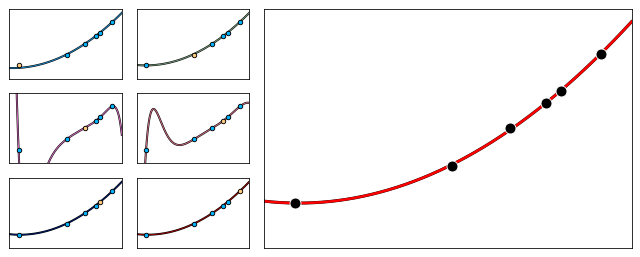

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# import data
csvname_1 = datapath + 'galileo_ramp_data.csv'

data = np.loadtxt(csvname_1,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

### container for outer loop - contains best model per split ###
best_individual_models = []
best_degs = []
num_pts = np.size(y)
num_splits = num_pts
top_degree = 10
all_val_costs = []

### run inner loop - one split ###
for s in range(num_splits):
    #### outer loop - make a run over one split of the data ####
    runs = []
    w = 0
    for j in range(1,top_degree+1):
        # initialize with input/output data
        mylib1 = nonlib.reg_lib.super_setup.Setup(x,y)

        # perform preprocessing step(s) - especially input normalization
        mylib1.preprocessing_steps(normalizer = 'standard')
        
        # generate indices for training set
        train_inds = np.arange(num_pts)

        # remove validation index
        train_inds = np.delete(train_inds, s)
        valid_inds = np.array([s])

        # inject into input / output
        mylib1.train_inds = train_inds
        mylib1.x_train = mylib1.x[:,train_inds]
        mylib1.y_train = mylib1.y[:,train_inds]

        mylib1.valid_inds = valid_inds
        mylib1.x_valid = mylib1.x[:,valid_inds]
        mylib1.y_valid = mylib1.y[:,valid_inds]
 
        # choose cost
        mylib1.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib1.choose_features(name = 'polys',degree = j)

        # fit
        mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False)

        # add model to list
        runs.append(copy.deepcopy(mylib1))
        
    ### keep lowest validation model from this run ###
    val_costs = [runs[i].valid_cost_histories[0][1] for i in range(top_degree)]
    
    # determine best model
    min_ind = np.argmin(val_costs) 
    best_degs.append(min_ind+1)
    min_val = val_costs[min_ind]
    best_model = runs[min_ind]

    # store 
    best_individual_models.append(copy.deepcopy(best_model))
    all_val_costs.append(val_costs)
    
# determine best overall model
all_val_costs = np.array(all_val_costs)
all_val_costs = all_val_costs[:,:,0]
mean_val_costs = np.mean(all_val_costs,0)
ind = np.argmin(mean_val_costs) + 1

### retrain best overall model on entire dataset ####
# initialize with input/output data
mylib1 = nonlib.reg_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib1.preprocessing_steps(normalizer = 'standard')

# generate indices for training set
train_inds = np.arange(num_pts)

# inject into input / output
mylib1.train_inds = train_inds
mylib1.x_train = mylib1.x[:,train_inds]
mylib1.y_train = mylib1.y[:,train_inds]

mylib1.valid_inds = []
mylib1.x_valid = np.array([])
mylib1.y_valid = np.array([])

# choose cost
mylib1.choose_cost(name = 'least_squares')

# choose dimensions of fully connected multilayer perceptron layers
mylib1.choose_features(name = 'polys',degree = ind)

# fit
mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False)

# plot each model individually, as well as the median model
demo1 = nonlib.kfolds_regression_visualizers.Visualizer(csvname_1)
demo1.show_runs(best_individual_models,mylib1)

## 11.6.2  K-folds and high dimensional linear modeling

Suppose for a moment we have a high capacity model which enable several kinds of overfitting behavior for a nonlinear regression datasets - with each overfitting provided different settings of the linear combination weights of the model (suppose any internal parameters of its features are fixed).  We illustrate such a scenario in the left panel below, where two settings of such a model provide two distinct overfitting predictors for a generic nonlinear regression dataset.   As we learned in Section 10.1, any *nonlinear model* in the original space of a regression dataset corresponds to a *linear model* in the transformed feature space (i.e., the space where each individual input axis is given by one of the chosen nonlinear feature).  Since our model easily overfits the original data, in the transformed feature space our data lies along a *linear subspace* that can be perfectly fit using many different hyperplanes.  Indeed the two nonlinear overfits shown in the left panel correspond one-to-one with the two linear fits in the transformed feature space - illustrated figuratively in the right panel of the figure.  In other words, a severely overfitting high capacity *nonlinear model* in the original regression space is severely overfitting high capacity *linear model* in the transformed feature space feature.  This fact holds regardless of the problem type as well (e.g., for classification too).

<img src= '../../mlrefined_images/nonlinear_superlearn_images/overfitting_linear.png' width="100%"/>

The general scenario detailed in the right panel above is precisely where we *begin* when using *linear models* with very *small dataset* that have *high input dimension* (that is small dataset size $P$ and large input dimension $N$): in such instances even a linear model has extremely high capacity and can easily overfit (virtually ruling out the use of more complicated nonlinear models).  We cannot get much simpler / lower capacity in terms of modeling, as a linear model is typically the simplest one we can use for learning, thus even in such high dimensional scenarios (where it has extremely high capacity) we must employ it.  

In order to properly tune the parameters of a high capacity model we intuitively turn to a cross-validation technique designed specifically to temper high capacity models in general: *regularization* (as described in Section 11.4).  Given the small amount of data at play to determine the best setting of the regularization parameter K-folds is commonly employed determine the proper regluarization parameter value and ultimately the parameters of the linear model.

This scenario - as we will discuss in examples below - often provides an interesting point of intersection with the notion of *feature selection via regularization* detailed in 9.6.  Employing the $\ell_1$ regularizer we can blunt the capacity of our high capacity linear model *while simultaneously* selecting important input features, making human-interpretability possible.

#### <span style="color:#a50e3e;">Example 2. </span>  Gene expression data 

Genome-wide association studies (GWAS) aim at understanding the connections between tens of thousands of genetic markers, taken from across the human genome of several subjects, with diseases like high blood pressure/cholesterol, heart disease, diabetes, various forms of cancer, and many others. These studies typically produce small datasets of high dimensional (input) genetic information taken from a  sample of patients with a given affliction and a control group of non-afflicted.  Thus regularization based cross-validation a useful tool for learning meaningful (linear) models for such data.  Moreover using a feature-selecting regularizer like the $\ell_1$ norm (as detailed in Section 9.6) can help researchers identfiy the handful of genes critical to affliction, which can both improve our undetstanding of disease and perhaps provoke development of gene-targeted therapies.

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/GWA.png' width="100%" height="70%" alt=""/>
</td>
</tr>

- K = 10 folds cross validation, using $\ell_1$ regularizer

In [3]:
import time
from IPython.display import clear_output

# function for assigning each point in a dataset to one of K folds
def assign_to_folds(L,K):
    # split data into k equal (as possible) sized sets
    order = np.random.permutation(L)
    c = np.ones((L,1))
    L = int(np.round((1/K)*L))
    for s in np.arange(0,K-2):
        c[order[s*L:(s+1)*L]] = s + 2
    c[order[(K-1)*L:]] = K
    return c

# load in dataset
csvname = datapath + 'new_gene_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# assign data to K folds
K = 10
num_pts = y.size
fold_nums = assign_to_folds(num_pts,K)
lams = np.linspace(0,20,100)

# loop over each fold and complete calculations
all_train_counts = []
all_valid_counts = []
for k in range(K):
    print ('running '  + str(k+1) + ' of ' + str(K) + ' rounds')
    
    # import lib
    mylib = nonlib.kfolds_reg_lib.superlearn_setup.Setup(x,y)

    # choose normalizer
    mylib.choose_normalizer(name = 'standard')

    # make training testing split
    train_inds = np.argwhere(fold_nums != k)
    train_inds = [v[0] for v in train_inds]
    valid_inds = np.argwhere(fold_nums == k)
    valid_inds = [v[0] for v in valid_inds]

    # inject into input / output
    mylib.train_inds = train_inds
    mylib.x_train = mylib.x[:,train_inds]
    mylib.y_train = mylib.y[:,train_inds]

    mylib.valid_inds = valid_inds
    mylib.x_valid = mylib.x[:,valid_inds]
    mylib.y_valid = mylib.y[:,valid_inds]

    # choose cost
    mylib.choose_cost(cost_name = 'softmax',reg_name = 'L1')

    # choose optimizer
    mylib.choose_optimizer('gradient_descent',max_its=100,alpha_choice='diminishing')

    # run regularization
    mylib.tryout_lams(lams)
    
    # record counts
    all_train_counts.append(copy.deepcopy(mylib.train_count_vals))
    all_valid_counts.append(copy.deepcopy(mylib.valid_count_vals))

print ('runs complete!')
time.sleep(1.5)
clear_output()

# compute misclassifications totals
all_train_counts = np.array(all_train_counts)
train_totals = np.sum(all_train_counts,0)

all_valid_counts = np.array(all_valid_counts)
valid_totals = np.sum(all_valid_counts,0)

best_valid_ind = np.where(valid_totals == valid_totals.min())[0][-1]
best_lam = lams[best_valid_ind]

### re-tune weights given optimal regularization parameter found via 
### k-folds cross-validation
# import lib
mylib2 = nonlib.kfolds_reg_lib.superlearn_setup.Setup(x,y)

# choose normalizer
mylib2.choose_normalizer(name = 'standard')

# make training testing split
train_inds = np.argwhere(fold_nums != -1)
train_inds = [v[0] for v in train_inds]
valid_inds = np.argwhere(fold_nums == -1)
valid_inds = [v[0] for v in valid_inds]

# inject into input / output
mylib2.train_inds = train_inds
mylib2.x_train = mylib2.x[:,train_inds]
mylib2.y_train = mylib2.y[:,train_inds]

mylib2.valid_inds = valid_inds
mylib2.x_valid = mylib2.x[:,valid_inds]
mylib2.y_valid = mylib2.y[:,valid_inds]

# choose cost
mylib2.choose_cost(cost_name = 'softmax',reg_name = 'L1')

# choose optimizer
mylib2.choose_optimizer('gradient_descent',max_its=200,alpha_choice='diminishing')

# run regularization
mylib2.tryout_lams(np.array([best_lam]))

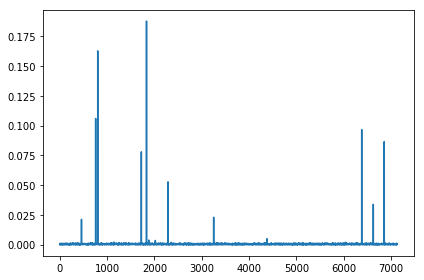

In [4]:
# plot best weights from cross-validated run
import matplotlib.pyplot as plt
plt.plot(np.abs(mylib2.best_weights[1:]))
plt.show()

#### <span style="color:#a50e3e;">Example 3. </span>  Brain scan 

Paired with a classification algorithm, Functional Magnetic Resonance Imaging (fMRI) of the brain is an increasingly useful method for diagnosing neurological disorders such as Autism, Alzheimer's, and Attention Deficit Hyperactivity Disorder (ADHD). To perform classification a dataset is acquired consisting of statistically-based features extracted from fMRI brain scans of patients suffering from one such previously mentioned cognitive disorder, as well as individuals from a control group who are not afflicted. These fMRI brain scans capture neural activity patterns localized in different regions of the brain as patients perform simple activities such as tracking a small visual object.

Neuroscientists believe that only a small number of active brain regions are involved in performing any given cognitive task. Therefore limiting the number of features allowed in the classification model, via sparse feature selection, is commonly done in order to produce high performing and human-interpretable results. Figure [fig:adhd-1] illustrates the result of applying a classification model with sparse feature selection to the problem of diagnosing patients with ADHD. The sparsely distributed regions of color represent activation areas uncovered by the learning algorithm which significantly distinguish between individuals with and without ADHD. 

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/brain.png' width="100%" height="70%" alt=""/>
</td>
</tr>